## 1. Data Setup

In [1]:
import h5py
import numpy as np

with h5py.File('training_data.h5', 'r') as f:
    flux = f['flux'][:]
    params = f['parameters'][:]
    labels = f['labels'][:]

class_names = ['sw', 'fs', 'msh', 'msp', 'ps', 'lobe']
class_to_idx = {'sw': 0, 'fs': 1, 'msh': 2, 'msp': 3, 'ps': 4, 'lobe':5}

PARAM_SIZE = params.shape[2]

import torch

X1_tensor = torch.from_numpy(flux).type(torch.float) # float is float32
X2_tensor = torch.from_numpy(params).type(torch.float) # float is float32
y_tensor = torch.from_numpy(labels).type(torch.LongTensor).squeeze()

nan_mask = torch.isnan(X2_tensor)
num_nan = torch.sum(nan_mask).item()
print("Number of NaNs:", num_nan)

# Replace NaN values with 0
X2_tensor = torch.nan_to_num(X2_tensor, nan=0.0)

# change to color, height, width, torch format
X1_tensor = torch.permute(X1_tensor, (0, 2, 1))
X1_tensor.size()

X2_tensor = torch.permute(X2_tensor, (0, 2, 1))

from sklearn.model_selection import train_test_split

# Split indices for training and testing
train_indices, test_indices = train_test_split(range(len(X1_tensor)), test_size=0.2, random_state=42)

# Use indices to split the datasets
X1_train, X1_test = X1_tensor[train_indices], X1_tensor[test_indices]
X2_train, X2_test = X2_tensor[train_indices], X2_tensor[test_indices]
y_train, y_test = y_tensor[train_indices], y_tensor[test_indices]


def min_max_scaling(tensor, feature_range=(0, 1)):
  """
  Scales a tensor to a specified range using min-max scaling.

  Args:
    tensor (torch.Tensor): The input tensor.
    feature_range (tuple, optional): The desired range for the scaled tensor. Defaults to (0, 1).

  Returns:
    torch.Tensor: The scaled tensor.
  """
  min_val = tensor.min()
  max_val = tensor.max()
  scaled_tensor = (tensor - min_val) / (max_val - min_val)

  #Adjust to the desired range
  scaled_tensor = scaled_tensor * (feature_range[1] - feature_range[0]) + feature_range[0]
  return scaled_tensor


min_vals_X1 = X1_train.min()
max_vals_X1 = X1_train.max()
X1_train = min_max_scaling(X1_train, feature_range=(0, 1))
min_vals_X1, max_vals_X1
X1_test = (X1_test - min_vals_X1) / (max_vals_X1 - min_vals_X1)

min_vals_X2 = torch.zeros(PARAM_SIZE)
max_vals_X2 = torch.zeros(PARAM_SIZE)

for i in range(0,PARAM_SIZE):
    min_vals_X2[i] = X2_train[:,i,:].min()
    max_vals_X2[i] = X2_train[:,i,:].max()
    # X2_tensor[:,:,i] = min_max_scaling(X2_tensor[:,:,i], feature_range=(-1, 1))
    X2_train[:,i,:] = min_max_scaling(X2_train[:,i,:], feature_range=(0, 1))
    X2_test[:,i,:] = (X2_test[:,i,:] - min_vals_X2[i]) / (max_vals_X2[i] - min_vals_X2[i])

X1_train = X1_train.unsqueeze(dim=1)
X1_test = X1_test.unsqueeze(dim=1)

Number of NaNs: 6


In [2]:
X1_train.shape, X1_test.shape, X2_train.shape, X2_test.shape, y_train.shape, y_test.shape

(torch.Size([473, 1, 32, 40]),
 torch.Size([119, 1, 32, 40]),
 torch.Size([473, 3, 40]),
 torch.Size([119, 3, 40]),
 torch.Size([473]),
 torch.Size([119]))

In [3]:
min_vals_X1, max_vals_X1, min_vals_X2, max_vals_X2

(tensor(0.),
 tensor(1.5701e+08),
 tensor([  0.6576,  19.5559, -23.5244]),
 tensor([  85.0814, 9750.4180,   16.6774]))

## 2. Model

In [4]:
from torch import nn

# Define the neural network
class MultiInputModel(nn.Module):
    def __init__(self):
        super(MultiInputModel, self).__init__()
        self.conv2d_1 = nn.Sequential(
            nn.Conv2d(in_channels=1, 
                      out_channels=16, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=16, 
                      out_channels=16,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv2d_2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv2d_3 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.conv1d_1 = nn.Sequential(
            nn.Conv1d(in_channels=3,
                     out_channels=16,
                     kernel_size=3, # how big is the square that's going over the image?
                     stride=1, # default
                     padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.BatchNorm1d(num_features=16),
            nn.ReLU(),
            nn.Conv1d(in_channels=16,
                      out_channels=16*2,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm1d(num_features=16*2),
            nn.ReLU(),
        )

        self.conv1d_2 = nn.Sequential(
            nn.Conv1d(in_channels=16*2,
                      out_channels=16,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm1d(num_features=16),
            nn.ReLU(),
            nn.AvgPool1d(kernel_size=2,
                         stride=2)
        )

        self.fc1 = nn.Linear(64*5*4, out_features=64)
        self.fc2 = nn.Linear(16*20, out_features=64)
        self.fc = nn.Linear(128, 6)
          
    def forward(self, x1, x2):
        # print(x1.shape)
        x1 = self.conv2d_1(x1)
        # print(x1.shape)
        x1 = self.conv2d_2(x1)
        x1 = self.conv2d_3(x1)
        # print(x1.shape)
        x1 = x1.view(x1.size(0), -1)  # Flatten hidden_units*10*8
        # print(x1.shape)
        x1 = self.fc1(x1)
        
        x2 = self.conv1d_1(x2)
        # print(x2.shape)
        x2 = self.conv1d_2(x2)
        # print(x2.shape)
        x2 = x2.view(x2.size(0), -1)  # Flatten hidden_units*20
        # print(x2.shape)
        x2 = self.fc2(x2)
        
        x = torch.cat((x1, x2), dim=1)  # Concatenate along feature dimension
        # print(x.shape)
        x = self.fc(x)
        # print(x.shape)
        return x

# Initialize model, loss function, and optimizer
model = MultiInputModel()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #changed from 0.001


## 3. Training 

In [5]:
from torchmetrics import Accuracy

# setup metric and make sure it's on target device
acc_fn = Accuracy(task="multiclass", num_classes=6)

results = {"epochs": [],
           "train_loss": [],
           "train_acc": [],
           "test_loss": [],
           "test_acc": []}

# Training loop
num_epochs = 20
batch_size = 8
num_samples = len(X1_train)
for epoch in range(num_epochs):
    train_loss, train_acc = 0, 0
    # print(epoch)
    for i in range(0, num_samples-1, batch_size):
        batch_X1 = X1_train[i:i+batch_size]
        batch_X2 = X2_train[i:i+batch_size]
        batch_y = y_train[i:i+batch_size]

        outputs = model(batch_X1, batch_X2)

        loss = criterion(outputs, batch_y)
        train_loss += loss
        train_acc += acc_fn(outputs.argmax(dim=1), batch_y)
        # print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss.item():.4f}, acc: {train_acc.item()*100:.2f}")
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_loss /= (len(X1_train)/batch_size)
    train_acc /= (len(X1_train)/batch_size)
    print(f"Epoch [{epoch+1}/{num_epochs}]: Train Loss: {train_loss.item():.4f}: Train acc: {train_acc.item()*100:.2f}%")
    results["epochs"].append(epoch)
    results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
    results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)


    test_loss, test_acc = 0, 0
    # Put model into evaluation mode
    model.eval()

    with torch.inference_mode():
        for i in range(0, len(X1_test), batch_size):
            batch_X1 = X1_test[i:i+batch_size]
            batch_X2 = X2_test[i:i+batch_size]
            batch_y = y_test[i:i+batch_size]
            # print(batch_y)

            test_pred = model(batch_X1, batch_X2)
            # print(test_pred.argmax(dim=1))
            test_loss += criterion(test_pred , batch_y)
            test_acc += acc_fn(test_pred.argmax(dim=1), batch_y)

        # test loss and accuracy average per batch
        test_loss /= (len(X1_test)/batch_size)
        test_acc /= (len(X1_test)/batch_size)
        print(f"\nEpoch [{epoch+1}/{num_epochs}]: Test loss: {test_loss:.4f}: Test acc: {test_acc*100:.2f}%\n")
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

        # if test_acc > 0.98:  # Condition to exit loop
        if test_loss < 0.05:  # Condition to exit loop
            print("Stopping early: Accuracy exceeded threshold!")
            break  # Exiting the loop
print("Training complete!")

Epoch [1/20]: Train Loss: 0.7920: Train acc: 75.69%

Epoch [1/20]: Test loss: 0.3210: Test acc: 78.39%

Epoch [2/20]: Train Loss: 0.1744: Train acc: 94.29%

Epoch [2/20]: Test loss: 0.1175: Test acc: 98.32%

Epoch [3/20]: Train Loss: 0.0713: Train acc: 98.73%

Epoch [3/20]: Test loss: 0.0608: Test acc: 100.00%

Epoch [4/20]: Train Loss: 0.0652: Train acc: 98.52%

Epoch [4/20]: Test loss: 0.0600: Test acc: 100.00%

Epoch [5/20]: Train Loss: 0.0527: Train acc: 98.94%

Epoch [5/20]: Test loss: 0.0596: Test acc: 100.00%

Epoch [6/20]: Train Loss: 0.0611: Train acc: 98.10%

Epoch [6/20]: Test loss: 0.0722: Test acc: 100.00%

Epoch [7/20]: Train Loss: 0.0438: Train acc: 98.94%

Epoch [7/20]: Test loss: 0.0617: Test acc: 100.00%

Epoch [8/20]: Train Loss: 0.0543: Train acc: 98.10%

Epoch [8/20]: Test loss: 0.0686: Test acc: 100.00%

Epoch [9/20]: Train Loss: 0.1181: Train acc: 95.77%

Epoch [9/20]: Test loss: 0.0668: Test acc: 99.16%

Epoch [10/20]: Train Loss: 0.0420: Train acc: 99.15%

Epoc

In [6]:
from tqdm.auto import tqdm

# Make predictions with trained model
num_samples = len(X1_test)
y_preds = []
model.eval()
with torch.inference_mode():
    for i in tqdm(range(0, num_samples, batch_size)):
        batch_X1 = X1_test[i:i+batch_size]
        batch_X2 = X2_test[i:i+batch_size]
        batch_y = y_test[i:i+batch_size]
        
        y_logit = model(batch_X1, batch_X2)
        y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) 

        y_preds.append(y_pred)

# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

  0%|          | 0/15 [00:00<?, ?it/s]

mlxtend version: 0.23.3


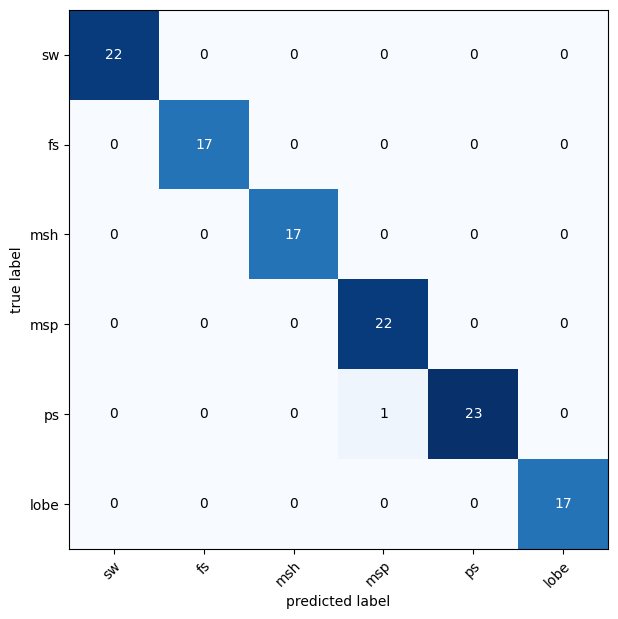

In [7]:
import matplotlib.pyplot as plt
import torchmetrics, mlxtend
print(f"mlxtend version: {mlxtend.__version__}")

from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# setup confusion matrix instance and compare predictions to target
confmat = ConfusionMatrix(num_classes=6, task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=y_test)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),  # matplotlib likes working with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10,7));
fig.savefig('ConfMatrix.png', dpi=fig.dpi)
plt.show()

n_classes 6
AUC macro average :0.9956686712485682
AUC micro average :0.9949579831932773


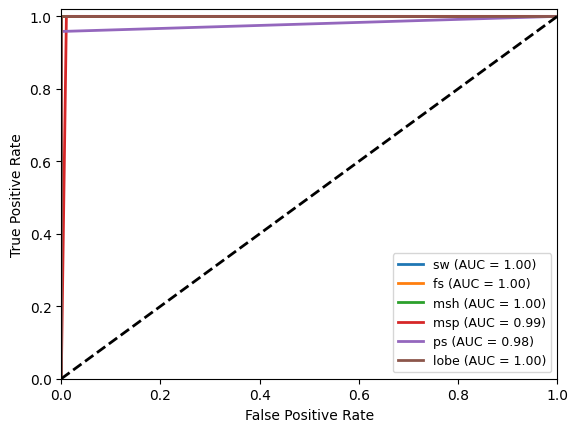

In [9]:
association = {0:'sw', 1: 'fs', 2:'msh', 3:'msp', 4:'ps', 5:'lobe'}

from utilities import roc_plot_rf

fig = roc_plot_rf(y_pred_tensor, y_test, association=association)
plt.show()

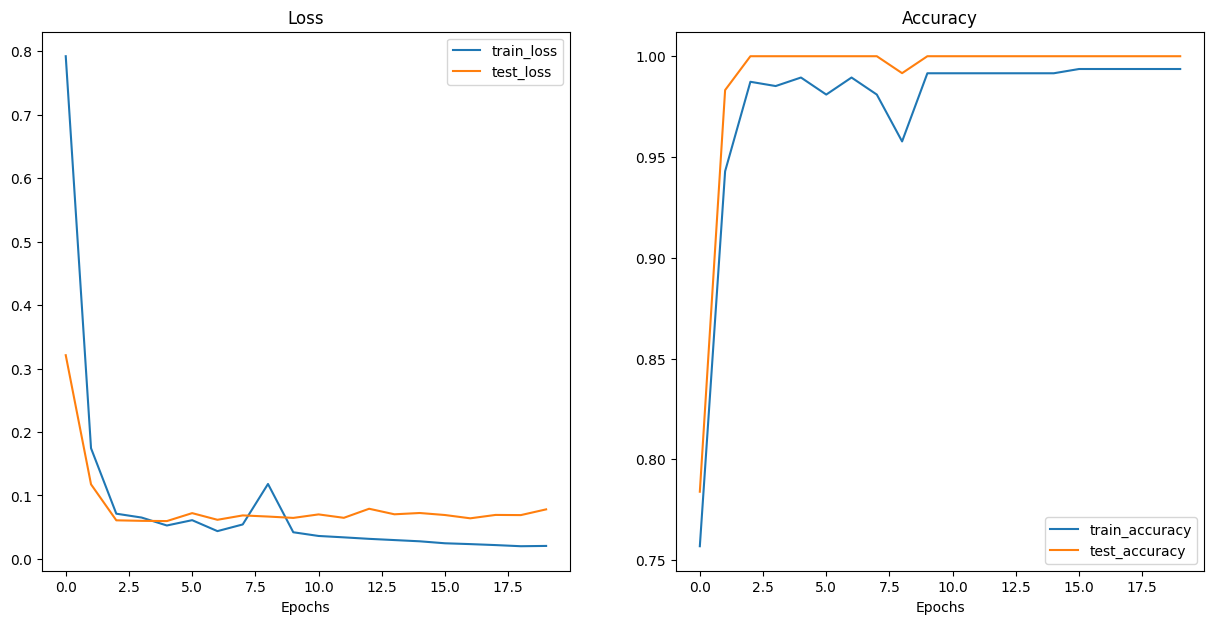

In [10]:
from utilities import plot_loss_curves

plot_loss_curves(results)

In [11]:
from torchmetrics import F1Score

# Initialize F1Score for multiclass task
f1_metric_multiclass = F1Score(task="multiclass", num_classes=6, average="macro") # or "micro", "weighted"

# Compute F1 score
f1_score_multiclass = f1_metric_multiclass(y_pred_tensor, y_test)
print(f"Multiclass F1 Score (macro avg): {f1_score_multiclass}")

Multiclass F1 Score (macro avg): 0.9927502870559692


## 4. Save the model

In [12]:
from pathlib import Path

# Create models directory (if it doesn't already exist), see: https://docs.python.org/3/library/pathlib.html#pathlib.Path.mkdir
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

# Create model save path
MODEL_NAME = "model01_fluxandBtTXsteps20.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/model01_fluxandBtTXsteps20.pth


09-Jul-25 17:05:50: Loading /Volumes/datadir/mmsdata/mms/mms1/fgm/srvy/l2/2015/09/mms1_fgm_srvy_l2_20150915_v4.18.0.cdf
09-Jul-25 17:05:53: Loading /Volumes/datadir/mmsdata/mms/mms1/fpi/fast/l2/dis-moms/2015/09/mms1_fpi_fast_l2_dis-moms_20150915060000_v3.4.0.cdf
09-Jul-25 17:05:53: Loading /Volumes/datadir/mmsdata/mms/mms1/fpi/fast/l2/dis-moms/2015/09/mms1_fpi_fast_l2_dis-moms_20150915080000_v3.4.0.cdf
09-Jul-25 17:05:53: Loading /Volumes/datadir/mmsdata/mms/mms1/fpi/fast/l2/dis-moms/2015/09/mms1_fpi_fast_l2_dis-moms_20150915100000_v3.4.0.cdf
09-Jul-25 17:05:53: Loading /Volumes/datadir/mmsdata/mms/mms1/fpi/fast/l2/dis-moms/2015/09/mms1_fpi_fast_l2_dis-moms_20150915120000_v3.4.0.cdf
09-Jul-25 17:05:53: Loading /Volumes/datadir/mmsdata/mms/mms1/fpi/fast/l2/dis-moms/2015/09/mms1_fpi_fast_l2_dis-moms_20150915140000_v3.4.0.cdf
09-Jul-25 17:05:53: Loading /Volumes/datadir/mmsdata/mms/mms1/fpi/fast/l2/dis-moms/2015/09/mms1_fpi_fast_l2_dis-moms_20150915160000_v3.4.0.cdf
09-Jul-25 17:05:54: Lo

Number of NaNs: 0


  0%|          | 0/33 [00:00<?, ?it/s]

09-Jul-25 17:05:57: /Users/naah5403/PyScripts/ML/Regions/region_modular/predict.py:168: RuntimeWarning: divide by zero encountered in log10
  np.log10(np.transpose(omni_flux.y[:,:])),cmap='nipy_spectral',shading='auto')



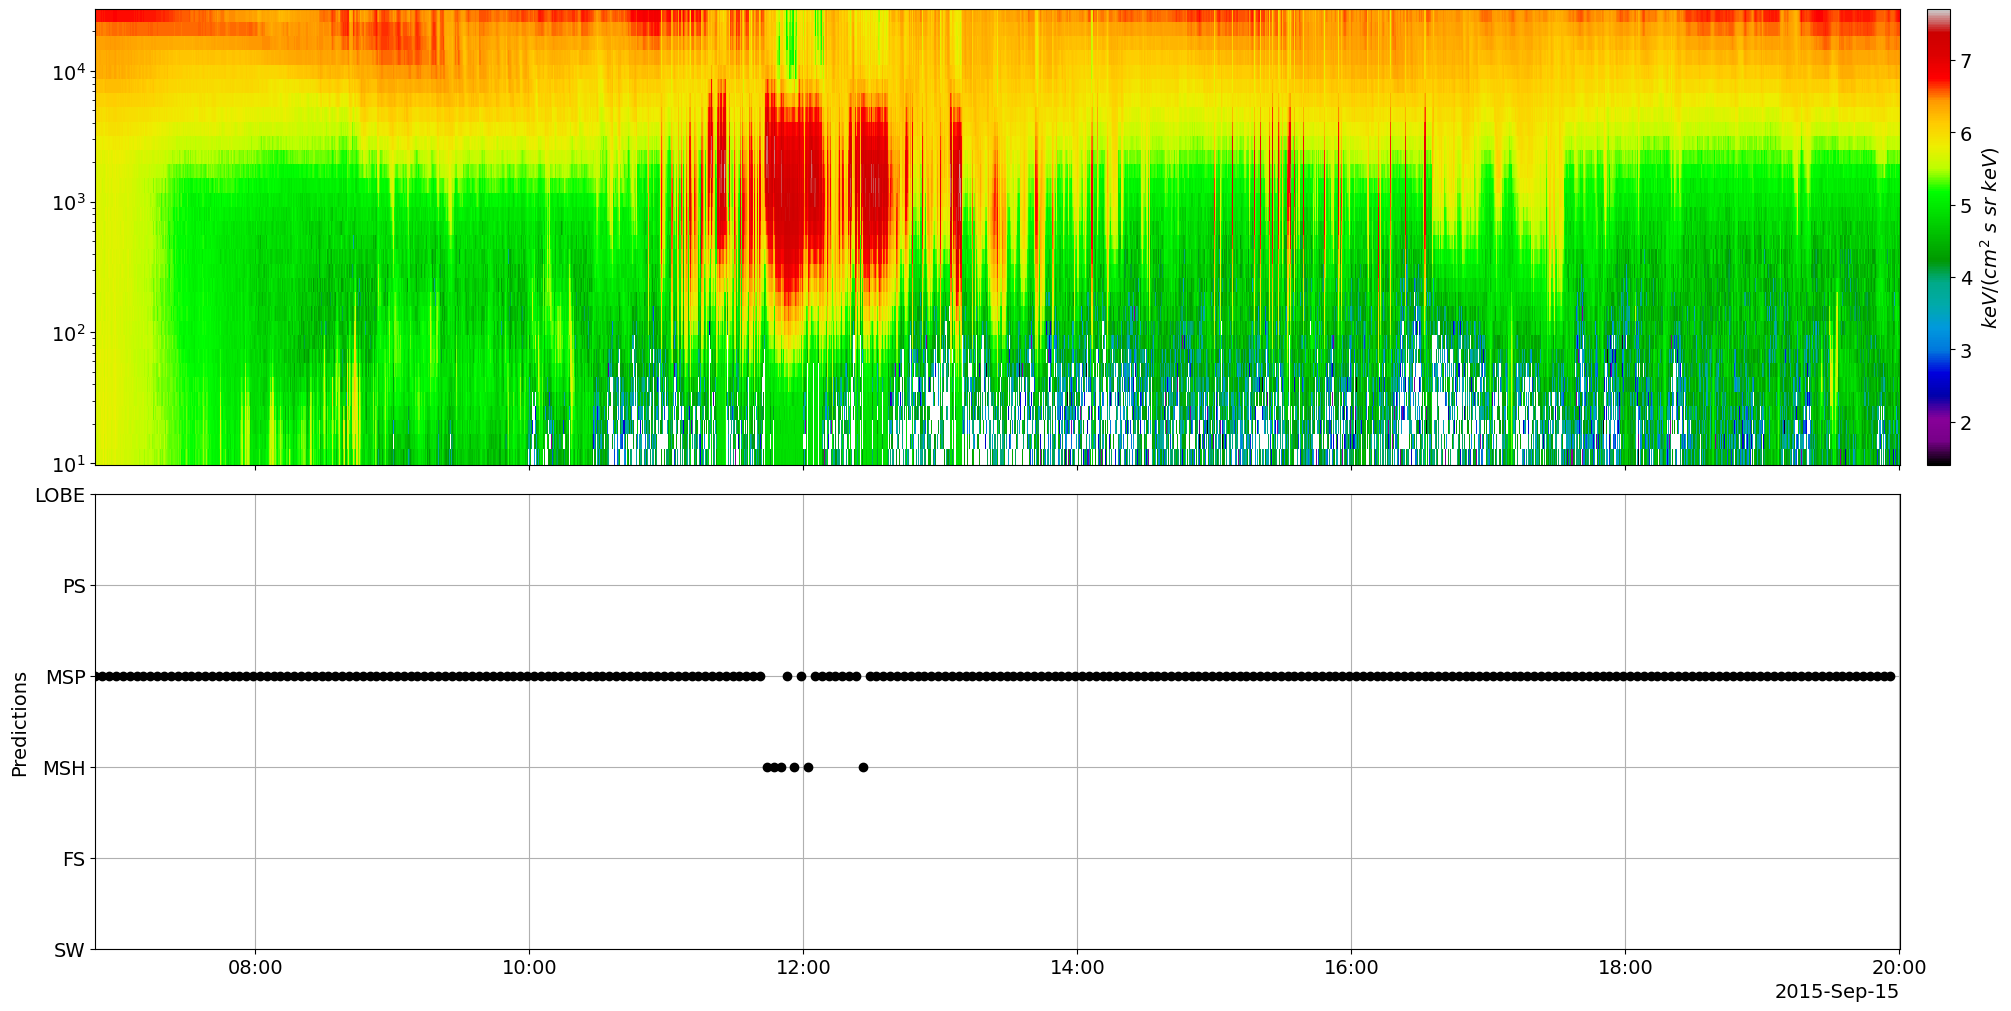

In [18]:
from predict import predictions
trange = ['2015-09-15/00:08:00', '2015-09-15/20:00:00']
predictions(model, trange)